In [1]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = r"D:\NUS_TERM2_CA2\Train"
TEST_DIR = r"D:\NUS_TERM2_CA2\Validation"


HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255)

datagen2 = ImageDataGenerator(
    rescale=1./255)


train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

validation_generator = datagen2.flow_from_directory(TEST_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)


class_list = ["food", "landmark", "people"]



Found 2424 images belonging to 3 classes.
Found 720 images belonging to 3 classes.


In [8]:
import numpy as np
import sklearn.metrics as metrics

seed = 29
np.random.seed(seed)

optmz = optimizers.Adam(lr=0.001)
# optmz = optimizers.RMSprop()

def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
  
    convLyr = Conv2D(numFilters,
                     kernel_size=kernelSz,
                     strides=strides,
                     padding='same',
                     kernel_initializer='he_normal',
                     kernel_regularizer=l2(1e-4),
                     name=lyrName + '_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName + '_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation, name=lyrName + '_' + activation if lyrName else None)(x)
        x = convLyr(x)
  
    return x


def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
  
    x = inputs
    for run in range(0, numBlocks):
        strides = 1
        blkStr = str(run + 1)
        
        if downsampleOnFirst and run == 0:
            strides = 2
            
        y = resLyr(inputs=x, numFilters=numFilters, strides=strides, lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y, numFilters=numFilters, activation=None, lyrName=names+'_Blk'+blkStr+'_Res2' if names else None) 
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x, numFilters=numFilters, kernelSz=1, 
                       strides=strides, activation=None, batchNorm=False, 
                       lyrName=names+'_Blk'+blkStr+'_lin' if names else None)

        x = add([x, y], name=names+'_Blk'+blkStr+'_add' if names else None) 

        x = Activation('relu',  name=names+'_Blk'+blkStr+'_relu' if names else None)(x)   

    return x


def createResNetV1(inputShape=(32, 32, 3),
                   numClasses=3):
  
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, numFilters=32, lyrName='Inpt')
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=False,
                 names='Stg1')
    v = Dropout(0.2)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg2')
    v = Dropout(0.2)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg3')
    v = Dropout(0.2)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg4')    
    v = Dropout(0.2)(v)
    
    v = resBlkV1(inputs=v,
                 numFilters=32,
                 numBlocks=3,
                 downsampleOnFirst=True,
                 names='Stg5')  

    v = AveragePooling2D(pool_size=8,
                         name='AvgPool')(v)
    v = Flatten()(v)
    outputs = Dense(numClasses,
                    activation='softmax',
                    kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optmz,
                  metrics=['accuracy'])
  
    return model

model = createResNetV1(inputShape=(HEIGHT, WIDTH, 3))  # This is meant for training
modelGo = createResNetV1(inputShape=(HEIGHT, WIDTH, 3))  # This is used for final testing
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 300, 300, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalization)    (None, 300, 300, 32) 128         Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 300, 300, 32) 0           Inpt_bn[0][0]                    
____________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
import matplotlib.pyplot as plt
from PIL import Image

NUM_EPOCHS = 100
BATCH_SIZE = 64
num_train_images = 2424
num_test_images = 720

def lrSchedule(epoch):
    lr = 1e-2

    if epoch > 160:
        lr *= 0.5e-3

    elif epoch > 120:
        lr *= 1e-3

    elif epoch > 80:
        lr *= 1e-2

    elif epoch > 5:
        lr *= 1e-1

    print('Learning rate: ', lr)

    return lr


LRScheduler = LearningRateScheduler(lrSchedule)

modelname = 'createResNetV1_32_nodes'
filepath = modelname + '.hdf5'

checkpoint = ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=0,
                            save_best_only=True,
                            mode='max')
csv_logger = CSVLogger(modelname + '.csv')

callbacks_list = [checkpoint, csv_logger, LRScheduler]

# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
                    
history = model.fit_generator(generator=train_generator,
                    validation_data=validation_generator,
                    epochs=NUM_EPOCHS,
                    workers=12, 
                    shuffle=True,
                    validation_steps=num_test_images // BATCH_SIZE,
                    steps_per_epoch=num_train_images // BATCH_SIZE, 
                    callbacks=callbacks_list)

Learning rate:  0.01
Epoch 1/100
37/37 [==============================] - 10s 284ms/step - loss: 1.0380 - acc: 0.6453 - val_loss: 203.8534 - val_acc: 0.3068
Learning rate:  0.01
Epoch 2/100
37/37 [==============================] - 9s 245ms/step - loss: 1.3189 - acc: 0.5135 - val_loss: 4.9893 - val_acc: 0.3068
Learning rate:  0.01
Epoch 3/100
37/37 [==============================] - 10s 262ms/step - loss: 1.1407 - acc: 0.5946 - val_loss: 1.4039 - val_acc: 0.4545
Learning rate:  0.01
Epoch 4/100
37/37 [==============================] - 10s 261ms/step - loss: 1.1123 - acc: 0.5980 - val_loss: 1.0278 - val_acc: 0.6477
Learning rate:  0.01
Epoch 5/100
37/37 [==============================] - 9s 255ms/step - loss: 1.1212 - acc: 0.5372 - val_loss: 0.9805 - val_acc: 0.6477
Learning rate:  0.01
Epoch 6/100
37/37 [==============================] - 9s 252ms/step - loss: 1.0070 - acc: 0.6014 - val_loss: 1.1896 - val_acc: 0.6023
Learning rate:  0.001
Epoch 7/100
37/37 [==============================

37/37 [==============================] - 10s 264ms/step - loss: 0.6754 - acc: 0.7635 - val_loss: 1.2667 - val_acc: 0.4659
Learning rate:  0.001
Epoch 54/100
37/37 [==============================] - 10s 257ms/step - loss: 0.6384 - acc: 0.7838 - val_loss: 0.8272 - val_acc: 0.6932
Learning rate:  0.001
Epoch 55/100
37/37 [==============================] - 10s 259ms/step - loss: 0.6175 - acc: 0.7905 - val_loss: 0.6656 - val_acc: 0.7500
Learning rate:  0.001
Epoch 56/100
37/37 [==============================] - 9s 252ms/step - loss: 0.6970 - acc: 0.7466 - val_loss: 0.5905 - val_acc: 0.8068
Learning rate:  0.001
Epoch 57/100
37/37 [==============================] - 10s 259ms/step - loss: 0.6402 - acc: 0.7601 - val_loss: 0.6054 - val_acc: 0.7841
Learning rate:  0.001
Epoch 58/100
37/37 [==============================] - 11s 285ms/step - loss: 0.6932 - acc: 0.7804 - val_loss: 0.5017 - val_acc: 0.8409
Learning rate:  0.001
Epoch 59/100
37/37 [==============================] - 10s 258ms/step - l

In [4]:
history_dict = history.history
history_dict.keys()

#

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

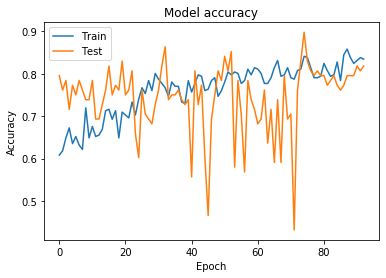

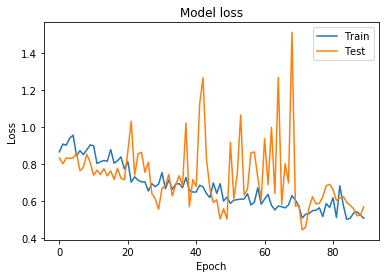

In [14]:
import matplotlib.pyplot as plt
# loss_values = history_dict['loss']
# val_loss_values = history_dict['val_loss']
plt.plot(history.history['acc'][7:])
plt.plot(history.history['val_acc'][7:])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = class_list #= ["food", "landmark", "people"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

90/90 [==============================] - 12s 137ms/step
Confusion Matrix
[[ 90 125  78]
 [ 63 109  46]
 [ 59  92  58]]
Classification Report
              precision    recall  f1-score   support

        food       0.42      0.31      0.36       293
    landmark       0.33      0.50      0.40       218
      people       0.32      0.28      0.30       209

    accuracy                           0.36       720
   macro avg       0.36      0.36      0.35       720
weighted avg       0.37      0.36      0.35       720



In [16]:
score = model.evaluate_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
print(model.metrics_names)
print(score)

90/90 [==============================] - 12s 135ms/step - loss: 0.5936 - acc: 0.7875
['loss', 'acc']
[0.5936039825280507, 0.7875]


In [ ]:
#Save & Load Model

In [8]:
model_json = model.to_json()
with open("ca2_model_32.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights('ca2_model_32.h5')
print("Saved model to disk")

Saved model to disk


In [9]:
from tensorflow.keras.models import model_from_json
# load json and create model
json_file = open('ca2_model_32.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("ca2_model_32.h5")
print("Loaded model from disk")

W0924 22:39:50.897940 14732 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 22:39:50.898906 14732 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0924 22:39:50.899904 14732 deprecation.py:506] From c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.ini

Loaded model from disk


In [10]:
loaded_model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
score = loaded_model.evaluate_generator(validation_generator, num_test_images//8, workers=12, verbose=1)
print(loaded_model.metrics_names)
print(score)

90/90 [==============================] - 13s 146ms/step - loss: 0.6007 - acc: 0.8056
['loss', 'acc']
[0.600727120704121, 0.8055556]
